In [ ]:
!pip install -U fvcore --quiet

In [ ]:
# this cell needs to be replaced with importing the Sklinear like:
# from panther.nn import SKLinear

import torch
import torch.nn as nn
from torch.autograd import Function


class SketchedLinearFunction(Function):
    @staticmethod
    def forward(h_in, U1s, U2s, S1s, S2s, bias, l):
        # Optimized version
        # Reshape tensors to use batch matrix multiplication
        # U1s: [l, k, d1] -> [l, d1, k]
        # S1s: [l, k, d2]
        # h_in: [d2, batch]
        U1s_t = U1s.transpose(1, 2)  # [l, d1, k]

        # Compute (U1s.T @ S1s @ h_in) for all l at once
        term1_fast = torch.bmm(
            U1s_t, torch.bmm(S1s, h_in.unsqueeze(0).expand(l, -1, -1))
        ).sum(0)

        # Compute (S2s @ U2s @ h_in) for all l at once
        term2_fast = torch.bmm(
            S2s, torch.bmm(U2s, h_in.unsqueeze(0).expand(l, -1, -1))
        ).sum(0)

        return ((term1_fast + term2_fast) / (2 * l)) + bias

    @staticmethod
    def setup_context(ctx, inputs, output):
        h_in, U1s, U2s, S1s, S2s, _, l = inputs
        ctx.save_for_backward(h_in, U1s, U2s, S1s, S2s)
        ctx.l = l

    @staticmethod
    def backward(ctx, grad_output):
        l = ctx.l
        h_in, U1s, U2s, S1s, S2s = ctx.saved_tensors

        # Optimized version using batch operations
        # Reshape for batch matrix multiplication
        grad_output_expanded = grad_output.unsqueeze(0).expand(l, -1, -1)
        h_in_t_expanded = h_in.T.unsqueeze(0).expand(l, -1, -1)

        # Compute grad_S1s and grad_S2s using batch operations
        grad_S1s_fast = torch.bmm(
            U1s, torch.bmm(grad_output_expanded, h_in_t_expanded)
        ) / (2.0 * l)
        grad_S2s_fast = torch.bmm(
            grad_output_expanded, torch.bmm(h_in_t_expanded, U2s.transpose(1, 2))
        ) / (2.0 * l)

        # Compute grad_hin terms using batch operations
        grad_hin_term1_fast = torch.bmm(
            S1s.transpose(1, 2), torch.bmm(U1s, grad_output_expanded)
        )
        grad_hin_term2_fast = torch.bmm(
            U2s.transpose(1, 2), torch.bmm(S2s.transpose(1, 2), grad_output_expanded)
        )
        grad_hin_fast = (grad_hin_term1_fast.sum(0) + grad_hin_term2_fast.sum(0)) / (
            2.0 * l
        )

        grad_b = grad_output.sum(1, keepdim=True)
        grad_U1s = grad_U2s = grad_l = None

        return (
            grad_hin_fast,
            grad_U1s,
            grad_U2s,
            grad_S1s_fast,
            grad_S2s_fast,
            grad_b,
            grad_l,
        )


def generate_U(k: int, d: int) -> torch.Tensor:
    """
    Generate a random matrix U with orthonormal rows.
    """
    return (torch.randint(0, 2, (k, d), dtype=torch.float64) * 2 - 1) / torch.sqrt(
        torch.tensor(k, dtype=torch.float64)
    )


class SKLinear(nn.Module):
    def __init__(self, d2, d1, l, k, bias_init_std=0.01, W=None):
        super(SKLinear, self).__init__()
        self.l = l
        self.k = k
        self.d1 = d1
        self.d2 = d2

        W = (
            torch.randn(d1, d2, dtype=torch.float64)
            if W is None
            else W.clone().detach()
        )

        self.register_buffer("U1s", torch.stack([generate_U(k, d1) for _ in range(l)]))
        self.register_buffer("U2s", torch.stack([generate_U(k, d2) for _ in range(l)]))
        self.S1s = nn.Parameter(torch.stack([self.U1s[i] @ W for i in range(l)]))
        self.S2s = nn.Parameter(torch.stack([W @ self.U2s[i].T for i in range(l)]))
        self.bias = nn.Parameter(
            torch.randn(d1, 1, dtype=torch.float64) * bias_init_std
        )

    def forward(self, h_in):
        x = SketchedLinearFunction.apply(
            h_in.T, self.U1s, self.U2s, self.S1s, self.S2s, self.bias, self.l
        )
        return x.T

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import t
from fvcore.nn import FlopCountAnalysis


# Define Simple Linear Model
class SimpleLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleLinear, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)


# Define Sketched Linear Model
class SketchedLinear(nn.Module):
    def __init__(
        self, input_dim, output_dim, num_terms, low_rank, bias_init_std=0.01, W=None
    ):
        super(SketchedLinear, self).__init__()
        self.fc = SKLinear(input_dim, output_dim, num_terms, low_rank, bias_init_std, W)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Function to compute confidence intervals
def confidence_interval(data, confidence=0.90):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    margin = std_err * t.ppf((1 + confidence) / 2.0, n - 1)
    return mean, margin

In [ ]:
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define function to measure FLOPS, Loss, and Time
def evaluate_model(
    model,
    input_tensor,
    target_tensor,
    criterion,
    optimizer,
    device,
    num_trials=10,
    confidence=0.90,
):
    global device_cpu, device_gpu
    model.to(device)
    model.eval()
    input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

    # FLOPS Calculation
    flops = FlopCountAnalysis(model, input_tensor).total()

    inference_times = []
    backprop_times = []
    losses = []

    for _ in range(num_trials):
        with torch.no_grad():
            if device == device_cpu:
                start_time = time.time()
            else:
                torch.cuda.synchronize()
                start_time = time.perf_counter()

            output = model(input_tensor)

            if device == device_cpu:
                inference_time = time.time() - start_time
            else:
                inference_time = time.perf_counter() - start_time

        model.train()
        output = model(input_tensor)  # Forward pass
        loss = criterion(output, target_tensor)

        if device == device_cpu:
            start_time = time.time()
        else:
            torch.cuda.synchronize()
            start_time = time.perf_counter()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if device == device_cpu:
            backprop_time = time.time() - start_time
        else:
            backprop_time = time.perf_counter() - start_time

        inference_times.append(inference_time)
        backprop_times.append(backprop_time)
        losses.append(loss.item())

    loss_mean, loss_margin = confidence_interval(losses, confidence)
    inf_mean, inf_margin = confidence_interval(inference_times, confidence)
    backprop_mean, backprop_margin = confidence_interval(backprop_times, confidence)

    return (
        flops,
        (loss_mean, loss_margin),
        (inf_mean, inf_margin),
        (backprop_mean, backprop_margin),
    )

In [ ]:
# Experiment Parameters
dimensions = [(1024, 512), (2048, 1024), (4096, 2048), (8192, 4096), (16384, 8192)]
batch_size = 64
num_trials = 20
confidence = 0.90

# Add sketching parameters
num_terms = 3
low_rank = 8

In [ ]:
torch.manual_seed(42)

metrics = {
    "Model": [],
    "Dimension": [],
    "Device": [],
    "FLOPS": [],
    "Loss Mean": [],
    "Loss Margin": [],
    "Inference Time Mean (s)": [],
    "Inference Time Margin (s)": [],
    "Backpropagation Time Mean (s)": [],
    "Backpropagation Time Margin (s)": [],
}

for input_dim, output_dim in dimensions:
    input_tensor = torch.randn(batch_size, input_dim, dtype=torch.float64)
    target_tensor = torch.randn(batch_size, output_dim, dtype=torch.float64)

    for device in [device_cpu, device_gpu]:
        for model_class, name, model_params in zip(
            [SimpleLinear, SketchedLinear],
            ["SimpleLinear", "SketchedLinear"],
            [
                {"input_dim": input_dim, "output_dim": output_dim},
                {
                    "input_dim": input_dim,
                    "output_dim": output_dim,
                    "num_terms": num_terms,
                    "low_rank": low_rank,
                },
            ],
        ):
            model = model_class(**model_params).double()
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            criterion = nn.MSELoss()

            flops, loss, inference_time, backprop_time = evaluate_model(
                model, input_tensor, target_tensor, criterion, optimizer, device
            )
            metrics["Model"].append(name)
            metrics["Dimension"].append(f"{input_dim}-{output_dim}")
            metrics["Device"].append(str(device))
            metrics["FLOPS"].append(flops)
            metrics["Loss Mean"].append(loss[0])
            metrics["Loss Margin"].append(loss[1])
            metrics["Inference Time Mean (s)"].append(inference_time[0])
            metrics["Inference Time Margin (s)"].append(inference_time[1])
            metrics["Backpropagation Time Mean (s)"].append(backprop_time[0])
            metrics["Backpropagation Time Margin (s)"].append(backprop_time[1])

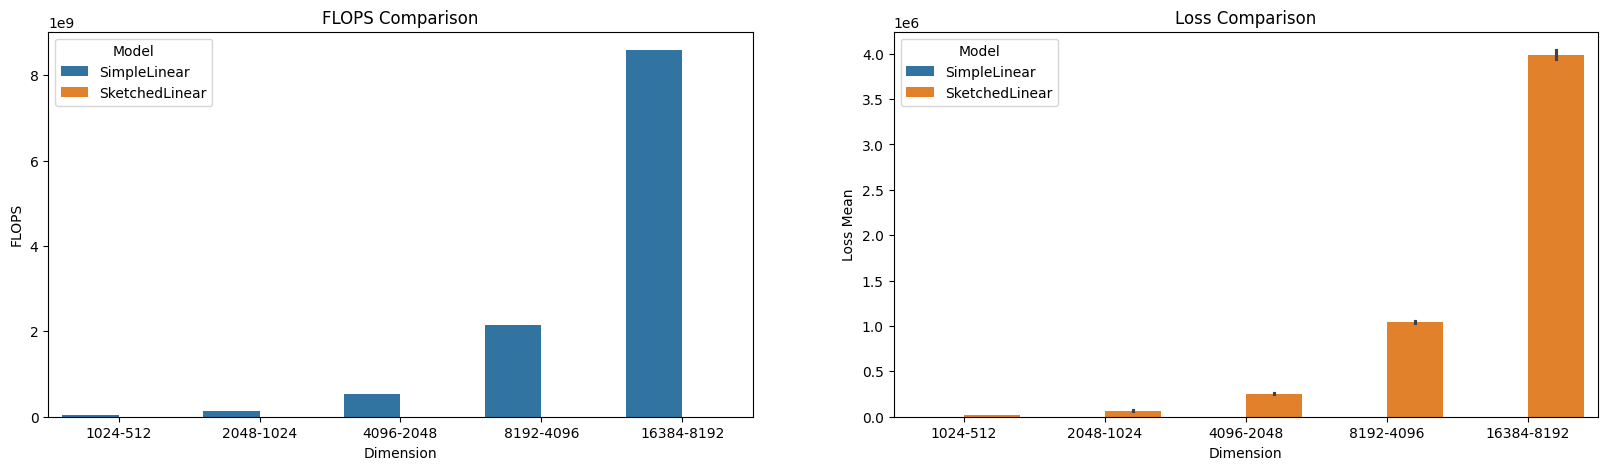

In [ ]:
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_factors = metrics_df.drop(columns=["Device"])
metrics_cpu = metrics_df[metrics_df["Device"] == str(device_cpu)]
metrics_gpu = metrics_df[metrics_df["Device"] == str(device_gpu)]

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# FLOPS & Loss (Independent of CPU/GPU)
sns.barplot(
    x="Dimension", y="FLOPS", hue="Model", data=metrics_factors, ax=axes[0]
).set_title("FLOPS Comparison")
sns.barplot(
    x="Dimension", y="Loss Mean", hue="Model", data=metrics_factors, ax=axes[1]
).set_title("Loss Comparison");

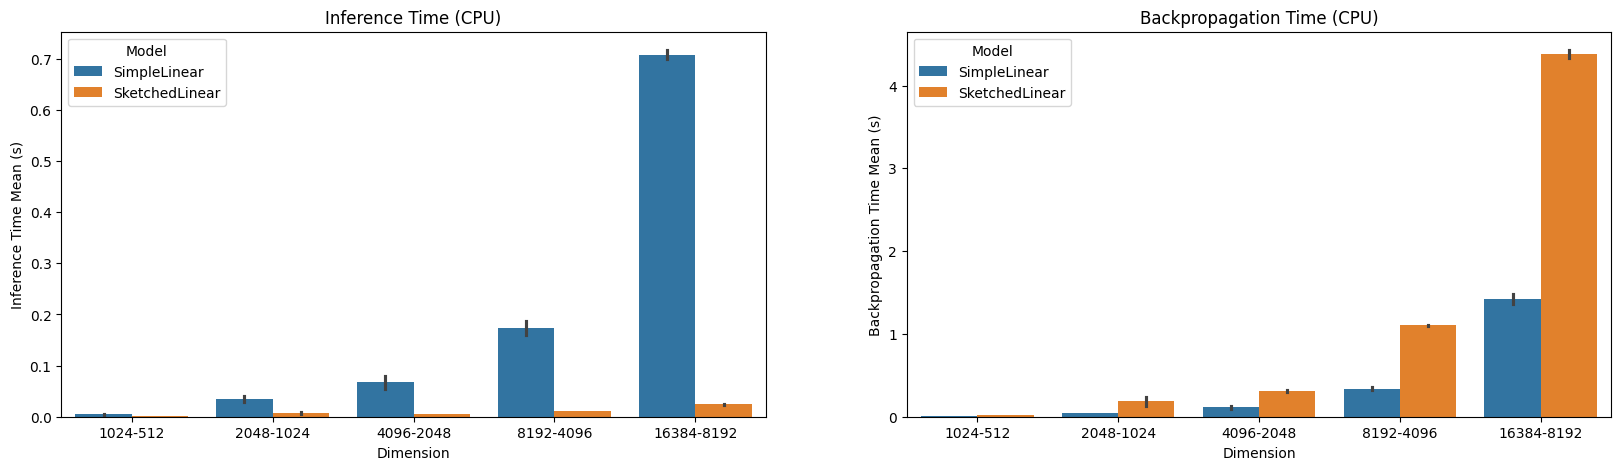

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# Inference & Backpropagation Time (CPU)
sns.barplot(
    x="Dimension",
    y="Inference Time Mean (s)",
    hue="Model",
    data=metrics_cpu,
    ax=axes[0],
).set_title("Inference Time (CPU)")
sns.barplot(
    x="Dimension",
    y="Backpropagation Time Mean (s)",
    hue="Model",
    data=metrics_cpu,
    ax=axes[1],
).set_title("Backpropagation Time (CPU)");

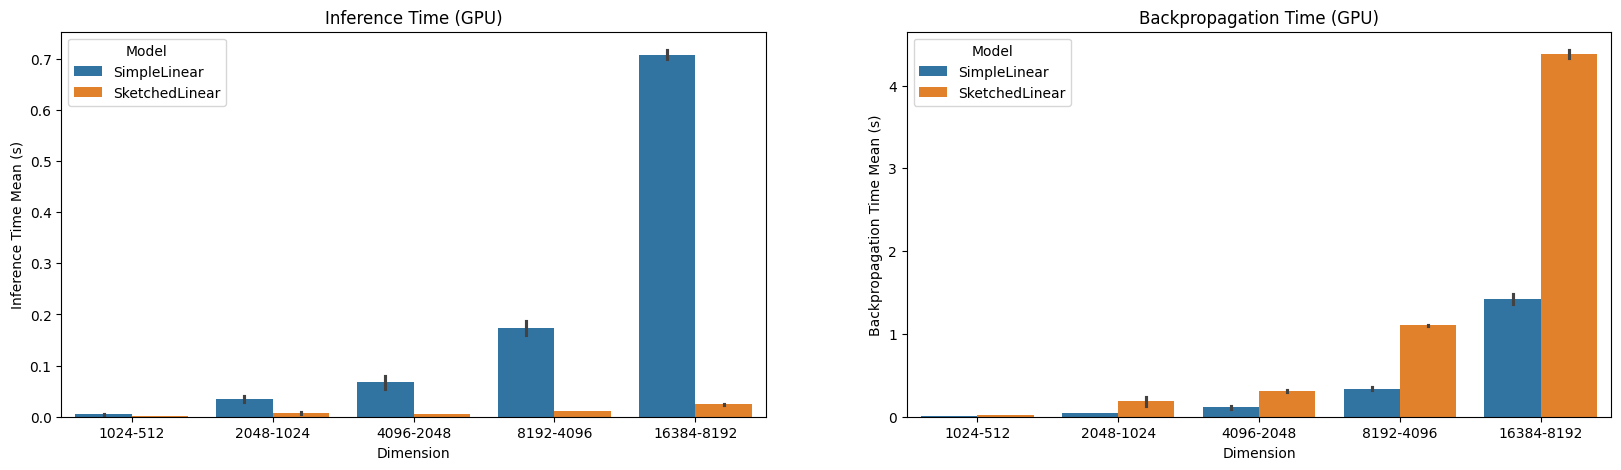

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# Inference & Backpropagation Time (GPU)
sns.barplot(
    x="Dimension",
    y="Inference Time Mean (s)",
    hue="Model",
    data=metrics_gpu,
    ax=axes[0],
).set_title("Inference Time (GPU)")
sns.barplot(
    x="Dimension",
    y="Backpropagation Time Mean (s)",
    hue="Model",
    data=metrics_gpu,
    ax=axes[1],
).set_title("Backpropagation Time (GPU)");

In [ ]:
print(
    metrics_df.assign(
        Loss=lambda df: df["Loss Mean"].map("{:.6f}".format)
        + " ± "
        + df["Loss Margin"].map("{:.6f}".format),
        **{
            "Inference Time (s)": lambda df: df["Inference Time Mean (s)"].map(
                "{:.6f}".format
            )
            + " ± "
            + df["Inference Time Margin (s)"].map("{:.6f}".format)
        },
        **{
            "Backpropagation Time (s)": lambda df: df[
                "Backpropagation Time Mean (s)"
            ].map("{:.6f}".format)
            + " ± "
            + df["Backpropagation Time Margin (s)"].map("{:.6f}".format)
        },
    )
    .drop(
        columns=[
            "Loss Mean",
            "Loss Margin",
            "Inference Time Mean (s)",
            "Inference Time Margin (s)",
            "Backpropagation Time Mean (s)",
            "Backpropagation Time Margin (s)",
        ]
    )
    .to_string(index=False)
)

         Model  Dimension Device      FLOPS                          Loss  Inference Time (s) Backpropagation Time (s)
  SimpleLinear   1024-512    cpu   33554432           1.345144 ± 0.003024 0.004225 ± 0.000401      0.008573 ± 0.002662
SketchedLinear   1024-512    cpu          0      17780.202194 ± 39.374897 0.002342 ± 0.000795      0.023065 ± 0.005415
  SimpleLinear   1024-512    cpu   33554432           1.332544 ± 0.002988 0.004677 ± 0.001022      0.006520 ± 0.002048
SketchedLinear   1024-512    cpu          0      17255.569564 ± 39.499296 0.001903 ± 0.000070      0.021696 ± 0.003367
  SimpleLinear  2048-1024    cpu  134217728           1.332246 ± 0.002954 0.029307 ± 0.008483      0.039784 ± 0.009447
SketchedLinear  2048-1024    cpu          0     70377.171460 ± 250.771858 0.008573 ± 0.003622      0.241374 ± 0.048572
  SimpleLinear  2048-1024    cpu  134217728           1.327090 ± 0.002944 0.041289 ± 0.009975      0.044144 ± 0.012201
SketchedLinear  2048-1024    cpu          0     